In [1]:
import json
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
from scipy.stats.kde import gaussian_kde
import scipy.signal as signal
%matplotlib inline
from IPython.html import widgets
from IPython.html.widgets import interact,fixed
from IPython.display import clear_output

from utils import \
    maybe_get_model,\
    persist_widget_value,\
    snd,\
    from_file,\
    to_file
    
from scipy.optimize import \
    curve_fit    
    
from toolz import \
    curry

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
model_filepath = '/notebooks/tmp/threshold-ui-model.json'
uiget = maybe_get_model(model_filepath) # key -> value
uiset = persist_widget_value(model_filepath) # widget -> key

In [3]:
# String -> String -> Float -> SideEffect[File]
def save_temp_threshold(condition,threshold):
    """ Save threshold (for specific condition) to file.
        This temp file will be read and merged with persistent file
         when save button is clicked. """
    data = {'Condition': condition,
            'Threshold': threshold}
    to_file('/notebooks/tmp/temp_threshold.json',json.dumps(data))
    
# String -> SideEffect[File]
def save_threshold(threshold_file):
    """ Given filepath to csv containing thresholds, 
        mutate the values based on the temporary threshold file. """
    temp_file = '/notebooks/tmp/temp_threshold.json'
    temp_threshold = json.loads(from_file(temp_file))
    thresholds = pd.read_csv(threshold_file)
    thresholds = thresholds.set_index('Condition')
    
    condition = temp_threshold['Condition']
    threshold = temp_threshold['Threshold']
    
    thresholds.loc[condition] = threshold
    thresholds = thresholds.reset_index()
    thresholds.to_csv(threshold_file,index=False)

In [4]:
execfile('/notebooks/assay-explorer/src/display_utils.py')

In [5]:
filepaths = {'ssC drug data': '/notebooks/moldev-data/analyzed/07-20-2015/ssC-cells.csv',
             'APB drug data': '/notebooks/moldev-data/analyzed/07-20-2015/APB-cells.csv'}
threshold_filepaths = {'ssC drug data': '/notebooks/moldev-data/analyzed/07-20-2015/ssC-thresholds.csv',
                       'APB drug data': '/notebooks/moldev-data/analyzed/07-20-2015/APB-thresholds.csv'}

In [6]:
mydataset = widgets.Dropdown(options=['ssC drug data','APB drug data'],
                             value = uiget('filename','ssC drug data'))
uiset(mydataset,'filename')

# Select dataset
Click `Cell > Run All` in the menu above to update the dataset shown.

In [7]:
mydataset

In [8]:
filepath = filepaths[mydataset.value]
threshold_filepath = threshold_filepaths[mydataset.value]

In [9]:
cells = pd.read_csv(filepath)

In [10]:
# [Float] -> Float
def get_threshold(intensity,bw = 0.35):
    """ Given an array of intensities, find the intensity 
        threshold separating the G1 peak from the S/G2 peak. """
    kde_fit = gaussian_kde(intensity,bw)
    x = np.linspace(min(intensity),
                    max(intensity),
                    1000)
    y = kde_fit(x)
    ddx = np.diff(np.diff(y)) # second derivative of fit
    peak = np.argmin(ddx) # most frequent intensity 
    index = min([yi for yi in signal.argrelmax(ddx)[0] if yi > peak])
    threshold = x[index]
    return threshold

In [11]:
# Create dummy file with thresholds
def get_threshold_from_group(group):
    groupname = group[0]
    groupdata = group[1]
    intensities = groupdata['NucIntegrated Intensity_Avg']
    return {'Condition': groupname,
            'Threshold': get_threshold(intensities,0.5)}

if not os.path.isfile(threshold_filepath):
    condition_groups = cells.groupby('Condition')
    initial_thresholds = pd.DataFrame(map(get_threshold_from_group,condition_groups))
    initial_thresholds.to_csv(threshold_filepath,index=False)

In [28]:
# Float -> Float -> Float -> Float -> Float
def gaussian(x,a,m,sd):
    """ Return value of gaussian at value x for 
        given amplitude, mean, and standard deviation. """
    return a * np.exp(-((x-m)**2.0)/(2.0*sd**2.0))

In [29]:
def constrained_double_gaussian(x,a1,m1,sd1,a2,sd2):
    """ Return value of x at for two summed gaussians. 
        The second gaussian has a mean twice that of the first. """
    g1 = gaussian(x,a1,m1,sd1)
    g2 = gaussian(x,a2,2.0*m1,sd2)
    return g1 + g2

In [30]:
x = np.arange(-10,10,0.05)

In [32]:
y = (lambda xi: gaussian(0.5,-5,np.sqrt(0.3),xi))(x)
y2 = (lambda xi: constrained_double_gaussian(xi,0.5,1,0.3,0.3,0.3))(x)

In [33]:
popt = curve_fit(constrained_double_gaussian,x,y2,[0.5,1,0.3,0.35,0.3])

In [34]:
popt[0]
yfit = (lambda xi: constrained_double_gaussian(xi,*popt[0]))(x)

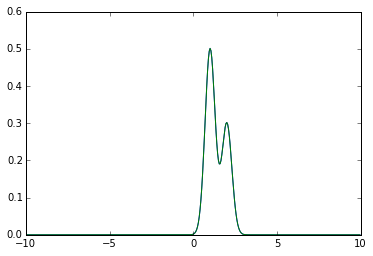

In [35]:
plt.plot(x,y2)
plt.plot(x,yfit)

In [47]:
# [Num] -> Float -> SideEffect[Plot]
def plot_gaussian_kde(X,bw,color='k',alpha=1):
    kde_fit = gaussian_kde(X,bw)
    x = np.linspace(min(X),
                    max(X),
                    1000)
    y = kde_fit(x)
    
    # Try fitting double gaussian
    popt,_ = curve_fit(constrained_double_gaussian,x,y,[4.2e-8,0.2e8,1.0e7,2e-8,1.0e7])
#     popt,_ = curve_fit(gaussian,x,y,[4.2e-8,0.2e8,1.0e7])
    yfit = (lambda xi: constrained_double_gaussian(xi,*popt))(x)
#     yfit = (lambda xi: gaussian(xi,*popt))(x)
    
    print popt
    plt.plot(x,y,color=color,alpha = alpha)
    plt.plot(x,yfit)

In [48]:
def determine_thresholding_parameters \
(data,condition,conditions,smoothness,manually_set_threshold,show):
    bw = smoothness
    method = show
    intensities = data[data['Condition'] == condition]['NucIntegrated Intensity_Avg']
    
    plot_gaussian_kde(intensities,bw,color='r')
    plt.title(condition)
    plt.xlim(0,1.5e8)
    plt.ylim(0,7e-8)
    
    # Plot thresholds
    auto_threshold = get_threshold(intensities,bw)
    threshold_data = pd.read_csv(threshold_filepath)
#     saved_threshold = threshold_data[threshold_data['Condition'] == condition]['Threshold'].values.tolist()[0]
    
    lw = 3
    alpha = 0.3
    
    if method == 'Auto':
        plt.plot([auto_threshold,auto_threshold],plt.gca().get_ylim(),color = 'r',linewidth = lw,alpha = alpha,label='Auto')
        save_temp_threshold(conditions,auto_threshold)
        plt.xlabel('NucIntegrated Intensity_Avg (threshold = {})'.format(auto_threshold))
    elif method == 'Manual':
        plt.plot([manually_set_threshold,manually_set_threshold],plt.gca().get_ylim(),color='g',linewidth = lw,alpha = alpha,label='Manual')
        save_temp_threshold(conditions,manually_set_threshold)
        plt.xlabel('NucIntegrated Intensity_Avg (threshold = {})'.format(manually_set_threshold))
        
    plt.legend()   

# Cell Phase Separation

[  3.58354658e-08   1.73102345e+07   8.12191852e+06   9.66573487e-09
   1.13569130e+07]


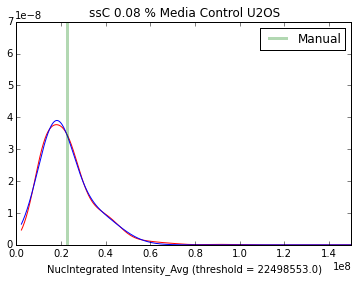

In [49]:
n_conditions = len(cells['Condition'].unique())
bw = {'min':0.025, 'max': 0.8, 'step':0.025}
intensities = cells['NucIntegrated Intensity_Avg']
thresh = {'min': intensities.min(),
          'max': intensities.max(),
          'step': (intensities.max() - intensities.min())/200,
          'init': intensities.median()}
# (data,condition,conditions,smoothness,manually_set_threshold,show):
interact(
    determine_thresholding_parameters,
    data = fixed(cells),
    condition = widgets.Dropdown(options = cells['Condition'].unique().tolist()),
    conditions = widgets.SelectMultiple(options = cells['Condition'].unique().tolist()),
    smoothness = widgets.FloatSlider(min = bw['min'], max = bw['max'], step = bw['step']),
    manually_set_threshold = widgets.FloatSlider(min = thresh['min'], max = thresh['max'], step = thresh['step'],value=thresh['init']),
    show = widgets.ToggleButtons(options=['Manual','Auto']));


In [44]:
save_button = widgets.Button(description='Save Threshold')

def save_my_threshold(_):
    clear_output()
    save_threshold(threshold_filepath)
    threshold_data = pd.read_csv(threshold_filepath)
    threshold_data['Cell Type'] = threshold_data['Condition'].map(lambda x: x.split(' ')[-1]) 
    threshold_data.sort('Cell Type').plot(kind='bar',x='Condition',y='Threshold')
#     display(threshold_data.sort('Cell Type')[['Condition','Threshold']])
    plt.xticks(rotation=45,ha='right')
    plt.gcf().set_size_inches(8, 3)
    plt.title('Thresholds for all conditions')
save_button.on_click(save_my_threshold)

In [45]:
save_button

In [152]:
def get_get_cell_phase_counts(data):
    condition = data['Condition'].tolist()[0]
    n_G1 = len(data[data['Cell Phase'] == 'G1'])
    n_G2 = len(data[data['Cell Phase'] == 'S/G2'])
    return {'Condition': condition,
            'Cell Type': condition.split(' ')[-1],
            '# G1 Cells': n_G1,
            '# S/G2 Cells': n_G2,
            'Fraction G1 Cells': float(n_G1) / (n_G1 + n_G2)}

In [153]:
def get_cell_phase_fractions(threshold_filepath,data):
    threshold_data = pd.read_csv(threshold_filepath)
    threshold_data['Cell Type'] = threshold_data['Condition'].map(lambda x: x.split(' ')[-1]) 
    threshold_data = threshold_data.sort('Cell Type')
    new_data = pd.merge(data,threshold_data,on='Condition')
    new_data['Cell Phase'] = new_data.apply(
        lambda d: 'G1' if d['NucIntegrated Intensity_Avg'] < d['Threshold'] else 'S/G2',
        axis = 1)
    condition_groups = new_data.groupby('Condition')
    return thread_first(
        new_data.groupby('Condition'),
        map(snd),
        map(get_get_cell_phase_counts),
        pd.DataFrame)

In [154]:
def plot_cell_phase_fractions(threshold_filepath,data):
    fractions = get_cell_phase_fractions(threshold_filepath,data)
    fractions.sort('Cell Type').plot(kind = 'bar', x = 'Condition', y = 'Fraction G1 Cells')
    plt.xticks(rotation=45,ha='right')
    plt.gcf().set_size_inches(8, 3)
    plt.title('Cell Phase Fractions')

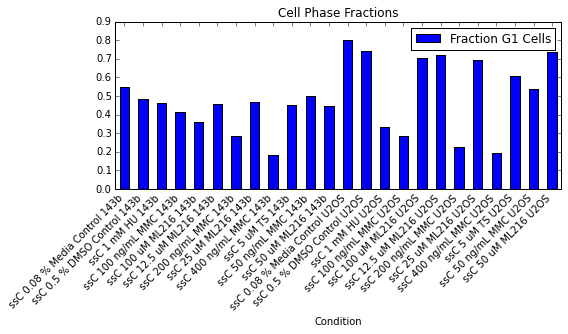

In [20]:
plot_cell_phase_fractions(threshold_filepath,cells);

In [21]:
d = pd.read_csv('/notebooks/moldev-data/db/db.csv')

In [23]:
# TODO: investigate Unnamed column!

In [24]:
groups = d.groupby(['Assay','Cell Type','Concentration','Contents'])

In [25]:
group_tuples = [(name,data) for name,data in groups]

In [56]:
g0 = group_tuples[25]

In [57]:
for i,g in enumerate(group_tuples):
    print i,g[0]
    

0 ('APB', '143b', 0.080000000000000002, 'Media Control')
1 ('APB', '143b', 0.5, 'DMSO Control')
2 ('APB', '143b', 1.0, 'HU')
3 ('APB', '143b', 5.0, 'TS')
4 ('APB', '143b', 12.5, 'ML216')
5 ('APB', '143b', 25.0, 'ML216')
6 ('APB', '143b', 50.0, 'ML216')
7 ('APB', '143b', 50.0, 'MMC')
8 ('APB', '143b', 100.0, 'ML216')
9 ('APB', '143b', 100.0, 'MMC')
10 ('APB', '143b', 200.0, 'MMC')
11 ('APB', '143b', 400.0, 'MMC')
12 ('APB', 'U2OS', 0.080000000000000002, 'Media Control')
13 ('APB', 'U2OS', 0.5, 'DMSO Control')
14 ('APB', 'U2OS', 1.0, 'HU')
15 ('APB', 'U2OS', 5.0, 'TS')
16 ('APB', 'U2OS', 12.5, 'ML216')
17 ('APB', 'U2OS', 25.0, 'ML216')
18 ('APB', 'U2OS', 50.0, 'ML216')
19 ('APB', 'U2OS', 50.0, 'MMC')
20 ('APB', 'U2OS', 100.0, 'ML216')
21 ('APB', 'U2OS', 100.0, 'MMC')
22 ('APB', 'U2OS', 200.0, 'MMC')
23 ('APB', 'U2OS', 400.0, 'MMC')
24 ('ssC', '143b', 0.080000000000000002, 'Media Control')
25 ('ssC', '143b', 0.5, 'DMSO Control')
26 ('ssC', '143b', 1.0, 'HU')
27 ('ssC', '143b', 5.0, 'TS')


In [60]:
g0_intensity = g0[1]['NucIntegrated Intensity_Avg']

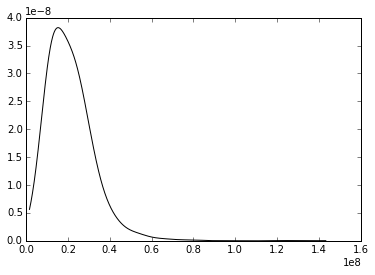

In [62]:
plot_gaussian_kde(g0_intensity,0.4)